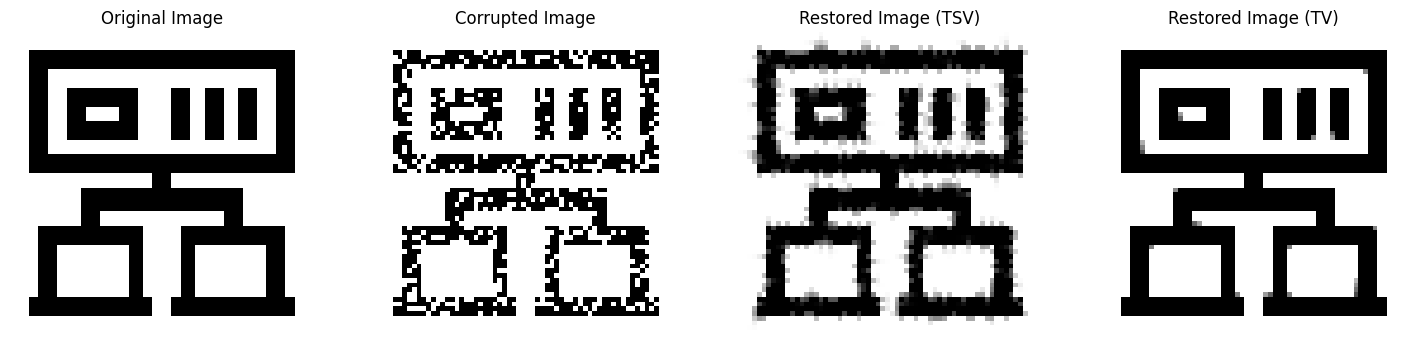

In [2]:
import numpy as np
import cv2  # For loading the image
import cvxpy as cp
import matplotlib.pyplot as plt

# Step 1: Load the image and define missing areas
image = cv2.imread('server64.png', cv2.IMREAD_GRAYSCALE)  # Load in grayscale
image = image.astype(float)

# Define the missing pixels (set some region to NaN to simulate missing data)
mask = np.ones_like(image, dtype=bool)
missing_fraction = 0.3  # Set 30% of the image as missing data 
num_missing_pixels = int(np.prod(image.shape) * missing_fraction)
missing_indices = np.random.choice(np.arange(np.prod(image.shape)), num_missing_pixels, replace=False)
mask.ravel()[missing_indices] = False
corrupted_image = np.copy(image)
corrupted_image[~mask] = np.nan  # Set the missing areas

# Step 2: Define the optimization problem for TSV minimization
def minimize_tsv(image, mask):
    m, n = image.shape
    I_hat = cp.Variable((m, n))
    
    # Objective function (Total Squared Variation)
    tsv = cp.sum_squares(I_hat[1:, :] - I_hat[:-1, :]) + cp.sum_squares(I_hat[:, 1:] - I_hat[:, :-1])
    
    # Constraints: I_hat equals the known values
    constraints = [I_hat[i, j] == image[i, j] for i in range(m) for j in range(n) if mask[i, j]]
    
    # Define the optimization problem
    problem = cp.Problem(cp.Minimize(tsv), constraints)
    
    # Solve the problem
    problem.solve()
    
    return I_hat.value

# Step 3: Define the optimization problem for TV minimization
def minimize_tv(image, mask):
    m, n = image.shape
    I_hat = cp.Variable((m, n))
    
    # Objective function (Total Variation)
    tv = cp.norm1(I_hat[1:, :] - I_hat[:-1, :]) + cp.norm1(I_hat[:, 1:] - I_hat[:, :-1])
    
    # Constraints: I_hat equals the known values
    constraints = [I_hat[i, j] == image[i, j] for i in range(m) for j in range(n) if mask[i, j]]
    
    # Define the optimization problem
    problem = cp.Problem(cp.Minimize(tv), constraints)
    
    # Solve the problem
    problem.solve()
    
    return I_hat.value

# Step 4: Solve the problems
tsv_solution = minimize_tsv(corrupted_image, mask)
tv_solution = minimize_tv(corrupted_image, mask)

# Step 5: Display the results
plt.figure(figsize=(18, 6))

plt.subplot(1, 4, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(corrupted_image, cmap='gray')
plt.title('Corrupted Image')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(tsv_solution, cmap='gray')
plt.title('Restored Image (TSV)')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(tv_solution, cmap='gray')
plt.title('Restored Image (TV)')
plt.axis('off')

plt.show()
